# Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:100%!important;width:auto!important;}</style>"))

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
def show_img(im, ax=None, figsize=(8,8), title=None):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3) 
    ax.imshow(im);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    if title: ax.set_title(title)
    return ax

In [4]:
def show_imgs(ims, rows=1, figsize=(16,8), title=[None]):
    title = title*len(ims) if len(title) == 1 else title
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    [show_img(im,ax_,title=tit) for im,ax_,tit in zip(ims,ax.flatten(),title)]
    return ax

# Convolutions

## The fully-connected layer problem

Let's assume that we want to build a neural network to classify (into one of $100$ classes) colour images of relatively high `4096x4096` resolution. 

In [ ]:
c, h, w = 3, 4096, 4096

In [ ]:
# batch of dummy data (BxCxHxW)
xb = torch.randn((16, c, h, w))
xb[0,0,:5,:5]

In [ ]:
# Logistic Regression network - this is supposed to crash!
net = nn.Sequential(
    nn.Linear(c*h*w, 100),
    nn.LogSoftmax(dim=1)
).cuda()

In [ ]:
out = net(xb.view(xb.shape[0],-1).cuda())

In [ ]:
c*h*w*100*4 / 1024**3

## Hierarchical structure of images

Images are made of elementary building blocks like *blobs* and *edges*. These can be combined to form more advanced shapes like *corners*. These in turn can lead to geometric shapes like *squares* etc. Following this reasoning one can eventually arrive at detailed real-life objects!

An important thing to realise is that an *edge* can (and will) appear anywhere in an image! The fully-connected/linear layer can't take advantage of that because each of its weights is hardwired to a particular input pixel.

## Convolutions explained

- Convolutions walkthrough in [Excel](https://livebournemouthac-my.sharepoint.com/:x:/g/personal/mbudka_bournemouth_ac_uk/EfUMp0FVIaFJl0UboP4xb3gBe2E2INDCKX79rLWa3QXlXA?e=DBU5AR)
- Yann Lecun's [paper on convolutions](http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf) from **1989!!**
- [LeNet-5 from 1999](http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf) is essentially the relatively modern architecture of [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) from 2012

# Simple CNN

In [5]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16,  out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
).cuda()

In [6]:
xb = torch.randn((16, 3, 256, 256)).cuda()

In [7]:
out = net(xb)
out.shape

torch.Size([16, 32, 64, 64])

## Shapes step by step

In [8]:
xb.shape

torch.Size([16, 3, 256, 256])

In [9]:
o1 = net[0](xb)
net[0]

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [10]:
o1.shape

torch.Size([16, 16, 256, 256])

In [11]:
o2 = net[1](o1)
net[1]

ReLU()

In [12]:
o2.shape

torch.Size([16, 16, 256, 256])

In [13]:
o3 = net[2](o2)
net[2]

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [14]:
o3.shape

torch.Size([16, 16, 256, 256])

In [15]:
o4 = net[3](o3)
net[3]

ReLU()

In [16]:
o4.shape

torch.Size([16, 16, 256, 256])

In [17]:
o5 = net[4](o4)
net[4]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [18]:
o5.shape

torch.Size([16, 16, 128, 128])

In [19]:
o6 = net[5](o5)
net[5]

Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [20]:
o6.shape

torch.Size([16, 32, 128, 128])

In [21]:
o7 = net[6](o6)
net[6]

ReLU()

In [22]:
o7.shape

torch.Size([16, 32, 128, 128])

In [23]:
o8 = net[7](o7)
net[7]

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [24]:
o8.shape

torch.Size([16, 32, 128, 128])

In [25]:
o9 = net[8](o8)
net[8]

ReLU()

In [26]:
o9.shape

torch.Size([16, 32, 128, 128])

In [27]:
o10 = net[9](o9)
net[9]

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [28]:
o10.shape

torch.Size([16, 32, 64, 64])

# Data

PyTorch comes with a number of common datasets out of the box. The full list is available [here](https://pytorch.org/docs/stable/torchvision/datasets.html).

In [29]:
from torchvision import datasets, transforms
from tempfile import TemporaryDirectory

In [30]:
d = TemporaryDirectory(prefix='STL10')
d.name

'C:\\Users\\user\\AppData\\Local\\Temp\\STL105ol75v6g'

In [31]:
tr_ds = datasets.STL10(root=d.name, split='train', download=True, transform=transforms.ToTensor())
tr_ds

0it [00:00, ?it/s]

100%|████████████████████████████████████████████████████████████▉| 2640183296/2640397119 [18:58<00:00, 2397932.35it/s]

Extracting C:\Users\user\AppData\Local\Temp\STL105ol75v6g\stl10_binary.tar.gz to C:\Users\user\AppData\Local\Temp\STL105ol75v6g


2640404480it [19:10, 2397932.35it/s]                                                                                   

Dataset STL10
    Number of datapoints: 5000
    Root location: C:\Users\user\AppData\Local\Temp\STL105ol75v6g
    Split: train
    StandardTransform
Transform: ToTensor()

In [32]:
val_ds = datasets.STL10(root=d.name, split='test', download=True, transform=transforms.ToTensor())
val_ds

Files already downloaded and verified


Dataset STL10
    Number of datapoints: 8000
    Root location: C:\Users\user\AppData\Local\Temp\STL105ol75v6g
    Split: test
    StandardTransform
Transform: ToTensor()

In [36]:
# without transform
ds = datasets.STL10(root=d.name, split='test', download=False)
ds[0]

(<PIL.Image.Image image mode=RGB size=96x96 at 0x1958E603D08>, 6)

In [37]:
tr_dl  = DataLoader(tr_ds,  batch_size=4, shuffle=True,  num_workers=2)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

In [38]:
xb, yb = next(iter(tr_dl))
xb.shape

torch.Size([4, 3, 96, 96])

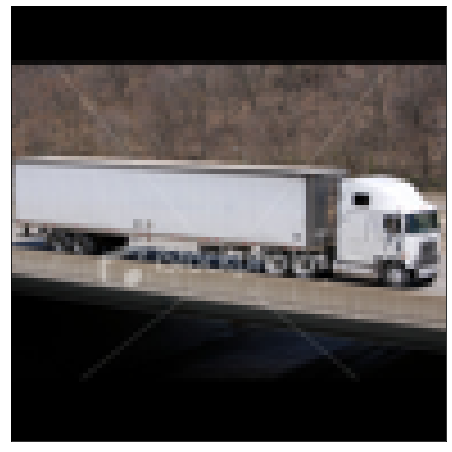

In [40]:
show_img(xb[0].numpy().transpose(1,2,0));

## Standardisation

As before, we need to calculate per-channel pixel intensity mean ($\mu$) and standard deviation ($\sigma$) to be able to standardise/normalise our data. The problem is that for bigger datasets, you can't simply load it all to memory to calculate these two like we did with Fashion-MNIST. We will have to use a trick here instead!

The formulae for the mean and standard deviation that we have used before are:

$\mu ={\frac {1}{N}}\sum _{i=1}^{N}x_{i}$

$\sigma ={\sqrt {{\frac {1}{N}}\sum _{i=1}^{N}(x_{i}-\mu )^{2}}}$

The issue is that in order to calculate $\sigma$, we need to know $\mu$, so a naïve approach will require **two passess** over the dataset.

We can however take advantage of the following (see [Wikipedia](https://en.wikipedia.org/wiki/Standard_deviation#Definition_of_population_values)), where $\operatorname {E} [X]=\mu$:

${\displaystyle {\begin{aligned}\sigma &={\sqrt {\operatorname {E} [(X-\mu )^{2}]}}\\&={\sqrt {\operatorname {E} [X^{2}]+\operatorname {E} [-2\mu X]+\operatorname {E} [\mu ^{2}]}}\\&={\sqrt {\operatorname {E} [X^{2}]-2\mu \operatorname {E} [X]+\mu ^{2}}}\\&={\sqrt {\operatorname {E} [X^{2}]-2\mu ^{2}+\mu ^{2}}}\\&={\sqrt {\operatorname {E} [X^{2}]-\mu ^{2}}}\\&={\sqrt {\operatorname {E} [X^{2}]-(\operatorname {E} [X])^{2}}}\end{aligned}}}$



The above calculation in [Excel](https://livebournemouthac-my.sharepoint.com/:x:/g/personal/mbudka_bournemouth_ac_uk/EbEmpdAesrZHkuHg4ijDIwcB09FgpcNxr_8NYjqE89lU_A?e=FbYgRB).

In [44]:
def get_stats(dl):
    cnt, csum, csum_sq = torch.zeros(1), torch.zeros(3), torch.zeros(3)
    
    for xb,_ in tqdm(dl):
        cnt += xb.shape[0]*xb.shape[2]*xb.shape[3]
        csum += xb.sum(dim=(0,2,3))
        csum_sq += (xb*xb).sum(dim=(0,2,3))

    μ = csum / cnt
    σ = (csum_sq / cnt - μ**2).sqrt()
    return μ, σ

stl10_stats = get_stats(tr_dl)
stl10_stats

(tensor([0.4467, 0.4398, 0.4066]), tensor([0.2603, 0.2566, 0.2713]))

In [46]:
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stl10_stats)
])

In [47]:
tr_ds  = datasets.STL10(root=d.name, split='train', download=True, transform=transf)
val_ds = datasets.STL10(root=d.name, split='test',  download=True, transform=transf)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
bs = 8
tr_dl  = DataLoader(tr_ds,  batch_size=bs,   shuffle=True,  num_workers=2)
val_dl = DataLoader(val_ds, batch_size=2*bs, shuffle=False, num_workers=2)

In [49]:
get_stats(tr_dl), get_stats(val_dl)

((tensor([-2.7652e-07, -8.2652e-07,  2.0298e-07]),
  tensor([1.0000, 1.0000, 1.0000])),
 (tensor([ 0.0020, -0.0007, -0.0062]), tensor([1.0009, 1.0003, 0.9952])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor(-1.7159), tensor(1.7536), tensor(-0.2833), tensor(0.6028))

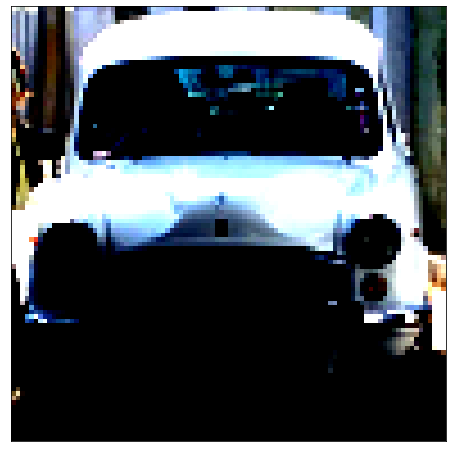

In [50]:
xb, yb = next(iter(tr_dl))
show_img(xb[1].numpy().transpose(1,2,0));
xb[0].min(), xb[0].max(), xb[0].mean(), xb[0].std()

# Training

## Network architecture

In [51]:
# input: [bs,3,h,w] - this network will accept *any* input resolution
net = nn.Sequential(
    nn.Conv2d(in_channels=3,  out_channels=16, kernel_size=3, stride=1, padding=1), nn.ReLU(), # [bs,16,h,w]
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1), nn.ReLU(), # [bs,16,h,w]
    nn.MaxPool2d(kernel_size=2, stride=2),                                                     # [bs,16,h/2,w/2]
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), nn.ReLU(), # [bs,32,h/2,w/2]
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1), nn.ReLU(), # [bs,32,h/2,w/2]
    nn.MaxPool2d(kernel_size=2, stride=2),                                                     # [bs,32,h/4,w/4]
#     nn.Flatten(), nn.Linear(32*64*64, 10)
).cuda()

In [52]:
xb, yb = next(iter(tr_dl))
xb.shape

torch.Size([8, 3, 96, 96])

In [58]:
o = net(xb.cuda())
o.shape

torch.Size([8, 32, 24, 24])

In [62]:
net1 = nn.Sequential(
    *net[:-1],
    nn.AdaptiveAvgPool2d((4,4))
)
net1

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=(4, 4))
)

In [63]:
net1(xb.cuda()).shape

torch.Size([8, 32, 4, 4])

In [64]:
dummy = torch.randn((16, 3, 256, 256)).cuda()
net(dummy).shape, net1(dummy).shape

(torch.Size([16, 32, 64, 64]), torch.Size([16, 32, 4, 4]))

In [65]:
dummy = torch.randn((16, 3, 128, 128)).cuda()
net(dummy).shape, net1(dummy).shape

(torch.Size([16, 32, 32, 32]), torch.Size([16, 32, 4, 4]))

In [66]:
dummy = torch.randn((16, 3, 256, 128)).cuda()
net(dummy).shape, net1(dummy).shape

(torch.Size([16, 32, 64, 32]), torch.Size([16, 32, 4, 4]))

In [71]:
net2 = nn.Sequential(
    *net[:-1],
    nn.AdaptiveAvgPool2d((4,4)),
    nn.Flatten(),
    nn.Linear(32*4*4,10)
).cuda()

In [72]:
net2(dummy).shape

torch.Size([16, 10])

## Training loop

In [73]:
def fit(net, tr_dl, val_dl, loss=nn.CrossEntropyLoss(), epochs=3, lr=3e-3, wd=1e-3):   
    
    Ltr_hist, Lval_hist = [], []
    
    opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    for epoch in trange(epochs):
        L = []
        dl = iter(tr_dl)
        for xb, yb in tqdm(dl, leave=False):
            xb, yb = xb.cuda(), yb.cuda()
            y_ = net(xb)
            l = loss(y_, yb)
            opt.zero_grad()
            l.backward()
            opt.step()
            L.append(l.detach().cpu().numpy())

        # disable gradient calculations for validation     
        for p in net.parameters(): p.requires_grad = False 

        Lval, Aval = [], []
        val_it = iter(val_dl)
        for xb, yb in tqdm(val_it, leave=False):
            xb, yb = xb.cuda(), yb.cuda()
            y_ = net(xb)
            l = loss(y_, yb)
            Lval.append(l.detach().cpu().numpy())
            Aval.append((y_.max(dim=1)[1] == yb).float().mean().cpu().numpy())

        # enable gradient calculations for next epoch 
        for p in net.parameters(): p.requires_grad = True 
            
        Ltr_hist.append(np.mean(L))
        Lval_hist.append(np.mean(Lval))
        print(f'training loss: {np.mean(L):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
    return Ltr_hist, Lval_hist

In [74]:
Ltr_hist, Lval_hist = fit(net2, tr_dl, val_dl, epochs=10)

training loss: 1.9289	validation loss: 2.0250	validation accuracy: 0.25


training loss: 1.6260	validation loss: 1.5957	validation accuracy: 0.41


training loss: 1.5038	validation loss: 1.4799	validation accuracy: 0.46


training loss: 1.4369	validation loss: 1.4822	validation accuracy: 0.44


training loss: 1.3980	validation loss: 1.3769	validation accuracy: 0.49


training loss: 1.3381	validation loss: 1.3906	validation accuracy: 0.50


training loss: 1.2897	validation loss: 1.3360	validation accuracy: 0.50


training loss: 1.2704	validation loss: 1.3067	validation accuracy: 0.52


training loss: 1.2265	validation loss: 1.2864	validation accuracy: 0.53


training loss: 1.1973	validation loss: 1.2719	validation accuracy: 0.54



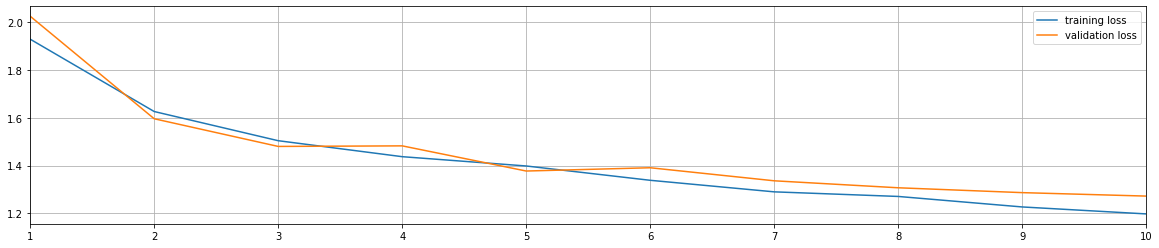

In [75]:
_,ax = plt.subplots(1,1,figsize=(20,4))
ax.plot(1+np.arange(len(Ltr_hist)),Ltr_hist)
ax.plot(1+np.arange(len(Lval_hist)),Lval_hist)
ax.grid('on')
ax.set_xlim(left=1, right=len(Ltr_hist))
ax.legend(['training loss', 'validation loss']);

# Homework

## For all

Train the neural network we have used in this notebook for maximum validation accuracy. Play with different values of the `learning rate` and `epochs`. Write down your results every time you train the network (i.e. for `lr=xx` and `epochs==yy`, `accuracy==zz`).

## For volunteers

Implement 2D convolution from scratch using loops. 